# Forecasting NQH2O Prices Using CALFEWS


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

Futures on the Nasdaq Veles California Water Index are available for trading through CME Group. Pricing Data download from [Nasdaq](https://indexes.nasdaqomx.com/Index/History/NQH2O). Weighting and industry breakdown needs subscription. 


Prices reflect the commodity value of water at the source and do not include additional costs associated with transportation or losses.
Water price data is:  
1. Aggregated from the five largest and most actively traded markets in California 
** central basin, chino basin, main san gabriel basin, mojave basin, surface water
2. Priced weekly in US$ per Acre Foot ($/AF)
3. Sourced weekly from Waterlitix™ – a pricing and market information database developed and maintained by WestWater Research
4. Data based on volume transacted across western market over past 10 yrs. Growth driven by expansion of high valued specialty crops in CA.

In [3]:
import os
print(os.getcwd())
os.chdir("C:/Users/danli/OneDrive - University of North Carolina at Chapel Hill/CAL_water_price_index")
print(os.getcwd())
# open .xlsx file
NQH2O_hist = pd.read_excel('NQH2O_20180801-20240819.xlsx')
NQH2O_hist.rename({'Trade Date': 'Date', 'Index Value': 'NQH2O'}, axis=1, inplace=True)
NQH2O_hist = NQH2O_hist[['Date', 'NQH2O']]
# NQH2O_hist.info()
NQH2O_pre = pd.read_csv('AdditionalData_NQH2O.csv', encoding='ISO-8859-1')
NQH2O_pre = NQH2O_pre[['Date', 'NQH2O']]
# NQH2O_pre
NQH2O_pre['Date'] = pd.to_datetime(NQH2O_pre['Date'])

c:\Users\danli\OneDrive - University of North Carolina at Chapel Hill\github\CALFEWS
C:\Users\danli\OneDrive - University of North Carolina at Chapel Hill\CAL_water_price_index


In [3]:
# Combining the datasets
combined_df = pd.concat([NQH2O_hist, NQH2O_pre]).sort_values(by='Date')
combined_df

,Date,NQH2O
0,2013-01-09,222.02
1,2013-01-16,146.89
2,2013-01-23,113.34
3,2013-01-30,109.68
4,2013-02-06,109.77
...,...,...
4,2024-07-17,408.06
3,2024-07-24,417.58
2,2024-07-31,429.86
1,2024-08-07,440.10


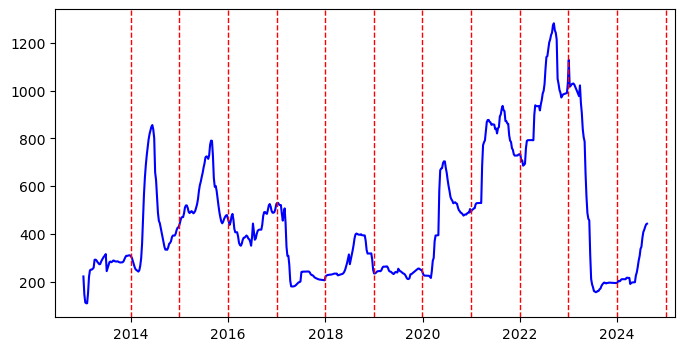

In [4]:
plt.figure(figsize=(8, 4))
plt.plot(combined_df['Date'], combined_df['NQH2O'], label='Price over time', color='blue')
# Adding vertical lines at the end of each year
for year in range(combined_df['Date'].dt.year.min(), combined_df['Date'].dt.year.max() + 1):
    plt.axvline(pd.Timestamp(f'{year}-12-31'), color='red', linestyle='--', linewidth=1)

plt.savefig('NQH2O_price_over_time.png')

# Visualization of kern county water agency

c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


,shpfl_nm,clfws_nm,geometry
0,Browns Valley Irrigation District,NA,"MULTIPOLYGON (((-121.36977 39.34022, -121.3699..."
1,Ramirez Water District,NA,"POLYGON ((-121.57380 39.26486, -121.56852 39.3..."
2,Cordua Irrigation District,NA,"POLYGON ((-121.47992 39.21311, -121.47991 39.2..."
3,Hallwood Irrigation District,NA,"POLYGON ((-121.57935 39.21993, -121.55747 39.2..."
4,Brophy Water District,NA,"POLYGON ((-121.55132 39.10619, -121.54978 39.1..."
5,South Yuba Water District,NA,"MULTIPOLYGON (((-121.51520 39.06192, -121.5151..."
6,Dry Creek Mutual Water Company,NA,"POLYGON ((-121.47687 38.99212, -121.47311 38.9..."
7,Wheatland Water District,NA,"MULTIPOLYGON (((-121.43503 39.07205, -121.4144..."


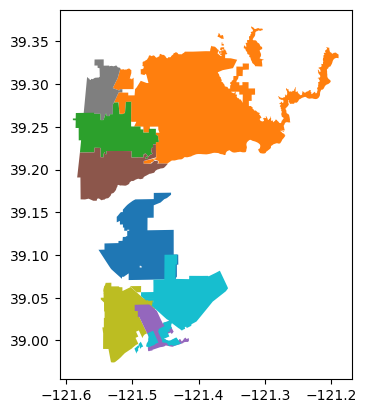

In [13]:
# read shapefile
import geopandas as gpd
os.chdir("C:/Users/danli/OneDrive - University of North Carolina at Chapel Hill/github/CALFEWS")
# current_directory
# shapefile = 'TransferGroupsCA/Kern County Water Agency/Kern County Water Agency.shp'
# for Folsom Dam & Canal
# shapefile = 'TransferGroupsCA/Folsom Dam & Canal/Folsom Dam & Canal.shp'
shapefile = 'TransferGroupsCA/Yuba Water Authority/Yuba Water Authority.shp'
gdf = gpd.read_file(shapefile)
# gdf.plot()
#understand the shapefile sturcture, and then extract the information you need
#for each shape, plot a different color
gdf.plot(column='shpfl_nm')
#print the geometry of the shapefile
# gdf.geometry
gdf
#print the geometry of the shapefile
#the display of geometry  is not complete
# print(gdf.geometry[4])



# Transfer data (Bulletin -132)

In [15]:
# Import necessary libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.impute import SimpleImputer

os.chdir("C:/Users/danli/OneDrive - University of North Carolina at Chapel Hill/github/CALFEWS")
# current_directory
#read csv file
df_buyer = pd.read_csv('maxs_work/bulletin_132_work/transfers_by_buyer.csv')
df_seller = pd.read_csv('maxs_work/bulletin_132_work/transfers_by_seller.csv')
df_buyer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Buyer                 283 non-null    object 
 1   Available Water (AF)  283 non-null    int64  
 2   Carriage Losses (AF)  283 non-null    object 
 3   Delivered             283 non-null    int64  
 4   Year                  283 non-null    int64  
 5   Type                  283 non-null    object 
 6   Price ($/AF)          240 non-null    float64
 7   Group                 2 non-null      object 
 8   Unnamed: 8            1 non-null      object 
dtypes: float64(1), int64(3), object(5)
memory usage: 20.0+ KB


In [16]:
# Step 1: Filter out rows where 'target' contains NaN
df_clean = df_buyer.dropna(subset=['Price ($/AF)'])

# Separate features and target variable
X = df_clean[['Available Water (AF)',  'Delivered','Year', 'Type']]  #'Carriage Losses (AF)',
y = df_clean['Price ($/AF)']

X = pd.get_dummies(X, columns=['Type'], drop_first=True)
X = sm.add_constant(X)

# Step 4: Perform multivariate linear regression using statsmodels
model = sm.OLS(y, X).fit()

# Step 5: Output the summary of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           Price ($/AF)   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     96.67
Date:                Wed, 02 Oct 2024   Prob (F-statistic):           2.19e-76
Time:                        12:00:00   Log-Likelihood:                -1392.3
No. Observations:                 240   AIC:                             2807.
Df Residuals:                     229   BIC:                             2845.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    -

In [17]:
df_seller

,Seller,Type,Volume (AF),Year,Additional Loss,Price ($/AF)
0,Butte Water District,Groundwater Substitution,2310,2020,0.0,NaN
1,Cordua Irrigation District,Groundwater Substitution,7142,2020,0.0,NaN
2,Garden Highway Mutual Water Company,Groundwater Substitution,4215,2020,0.0,NaN
3,Sutter Extension Water District,Groundwater Substitution,2308,2020,0.0,NaN
4,Tule Basin Farms,Groundwater Substitution,2462,2020,0.0,NaN
...,...,...,...,...,...,...
124,Tule Basin Farms,Groundwater Substitution,3098,2010,0.0,NaN
125,Western Canal Water District,Fallowing,24564,2010,0.0,NaN
126,Yuba River Water Authority,Yuba Accords C1,60000,2010,0.0,64.0
127,Yuba River Water Authority,Yuba Accords C3,15645,2010,0.0,75.0


In [18]:
# Step 1: Filter out rows where 'target' contains NaN
df_clean = df_seller.dropna(subset=['Price ($/AF)'])

# Separate features and target variable
X = df_clean[['Volume (AF)',  'Additional Loss','Year', 'Type']]  #'Carriage Losses (AF)',
y = df_clean['Price ($/AF)']

X = pd.get_dummies(X, columns=['Type'], drop_first=True)
X = sm.add_constant(X)

# Step 4: Perform multivariate linear regression using statsmodels
model = sm.OLS(y, X).fit()

# Step 5: Output the summary of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           Price ($/AF)   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     9.641
Date:                Wed, 02 Oct 2024   Prob (F-statistic):           6.93e-06
Time:                        12:01:35   Log-Likelihood:                -190.89
No. Observations:                  33   AIC:                             399.8
Df Residuals:                      24   BIC:                             413.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

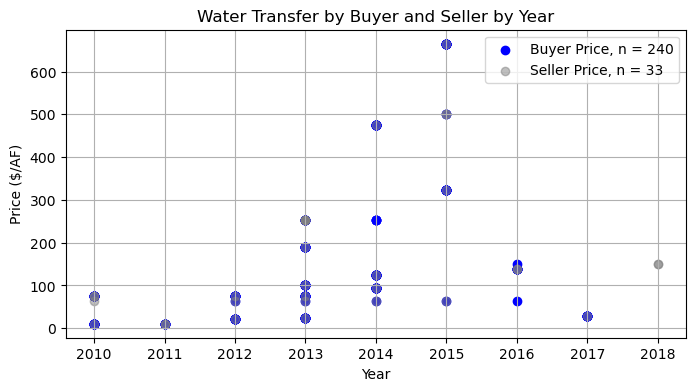

In [27]:
# df_seller['Type'] = 'Seller'
# df_buyer['Type'] = 'Buyer'

# # Step 3: Combine both dataframes
# combined_df = pd.concat([seller_df, buyer_df])

# Step 4: Plot the scatter plot
plt.figure(figsize=(8, 4))

# Scatter plot for seller prices
plt.scatter(df_buyer['Year'],
            df_buyer['Price ($/AF)'],
            color='blue', label='Buyer Price, n = 240')

# Scatter plot for buyer prices
plt.scatter(df_seller['Year'],
            df_seller['Price ($/AF)'],
            color='grey',alpha= 0.5, label='Seller Price, n = 33')

# Step 5: Customize the plot
plt.title('Water Transfer by Buyer and Seller by Year')
plt.xlabel('Year')
plt.ylabel('Price ($/AF)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Align data (CALFEWS output + NQH2O)

In [29]:
import os

# Get the current working directory
current_directory = os.getcwd()

os.chdir("C:/Users/danli/OneDrive - University of North Carolina at Chapel Hill/github/CALFEWS")
current_directory

'C:\\Users\\danli\\OneDrive - University of North Carolina at Chapel Hill\\github\\CALFEWS'

In [20]:
# !pip install cython

In [30]:
%load_ext cython

In [31]:

%%cython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import sys
from configobj import ConfigObj
import json
from distutils.util import strtobool
import h5py
from calfews_src.model_cy cimport Model
from calfews_src.inputter_cy import Inputter
from calfews_src.scenario import Scenario
from calfews_src.util import *
from calfews_src.plotter import *
from calfews_src.visualizer import Visualizer
from datetime import datetime

In [33]:
# import libraries
import numpy as np
import pandas as pd
import h5py
import json
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import compress
import os
from datetime import datetime
from calfews_src import *
from calfews_src.visualizer import Visualizer

# results hdf5 file location from CALFEWS simulations
output_folder = "results/28-year_example/"
output_file = output_folder + 'results.hdf5'
fig_folder = output_folder + 'figs/'

# now load simulation output
datDaily = get_results_sensitivity_number_outside_model(output_file, '')



In [34]:
datDaily

,shasta_S,shasta_R,shasta_R_to_delta,shasta_available_storage,shasta_outflow_release,shasta_days_til_full,shasta_Q,shasta_SNPK,shasta_downstream,shasta_fnf,...,kgr_FKC_flow,kgr_KWD_flow,kgr_TLB_flow,kgr_CNS_turnout,kgr_ALT_turnout,kgr_KRWA_turnout,kgr_FRS_turnout,kgr_FKC_turnout,kgr_KWD_turnout,kgr_TLB_turnout
1995-10-01,4552.000000,6.446281,6.446281,1776.000000,5.465113e+03,999.990000,0.000000,0.2,18.801322,0.009906,...,0.781584,0.781584,0.390792,0.807646,0.243230,1.246515,0.513950,0.0,0.390792,0.390792
1995-10-02,4545.281983,6.446281,6.446281,1897.343235,5.455773e+03,999.990000,10.393388,0.2,6.795372,0.009906,...,0.000000,0.000000,0.000000,0.225233,0.149913,0.000000,0.418451,0.0,0.000000,0.000000
1995-10-03,4548.820496,9.538204,9.538204,2102.057929,5.446433e+03,999.990000,7.537190,0.2,7.547107,0.009906,...,0.166853,0.166853,0.083426,0.347436,0.168695,0.258383,0.435049,0.0,0.083426,0.083426
1995-10-04,4546.615185,13.293615,13.293615,3147.489480,5.437093e+03,82.495605,6.852893,0.2,6.856859,0.009906,...,0.506971,0.506971,0.253485,0.597885,0.207879,0.775705,0.472051,0.0,0.253485,0.253485
1995-10-05,4539.698429,16.556986,16.556986,2372.331843,5.427753e+03,77.723376,8.419835,0.2,7.624463,0.009906,...,0.498689,0.498689,0.249345,0.589857,0.205942,0.749846,0.467930,0.0,0.249345,0.249345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-26,3068.049920,16.557520,15.864334,855.870529,4.347240e+01,999.990000,6.926281,161.0,0.910413,0.009319,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.485256,0.000000,0.0,0.000000,0.000000
2023-09-27,3058.404796,17.522603,16.776671,850.344945,3.260430e+01,999.990000,7.267438,161.0,-0.049587,0.009319,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.415882,0.000000,0.0,0.000000,0.000000
2023-09-28,3048.006822,17.131088,15.765872,843.805378,2.173620e+01,999.990000,6.963967,161.0,-0.654545,0.009319,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.440875,0.000000,0.0,0.000000,0.000000
2023-09-29,3037.556065,17.963987,16.776403,836.207306,1.086810e+01,999.990000,10.587769,161.0,-0.474050,0.009319,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.465450,0.000000,0.0,0.000000,0.000000


In [35]:
print(list(datDaily.keys()))
# start with berrenda_tableA_delivery outhbay_tableA_turnback', 

['shasta_S', 'shasta_R', 'shasta_R_to_delta', 'shasta_available_storage', 'shasta_outflow_release', 'shasta_days_til_full', 'shasta_Q', 'shasta_SNPK', 'shasta_downstream', 'shasta_fnf', 'oroville_S', 'oroville_R', 'oroville_R_to_delta', 'oroville_available_storage', 'oroville_outflow_release', 'oroville_days_til_full', 'oroville_Q', 'oroville_SNPK', 'oroville_downstream', 'oroville_fnf', 'yuba_S', 'yuba_R', 'yuba_R_to_delta', 'yuba_available_storage', 'yuba_outflow_release', 'yuba_days_til_full', 'yuba_Q', 'yuba_SNPK', 'yuba_downstream', 'yuba_fnf', 'folsom_S', 'folsom_R', 'folsom_R_to_delta', 'folsom_available_storage', 'folsom_outflow_release', 'folsom_days_til_full', 'folsom_Q', 'folsom_SNPK', 'folsom_fnf', 'newmelones_S', 'newmelones_R', 'newmelones_R_to_delta', 'newmelones_Q', 'newmelones_SNPK', 'newmelones_downstream', 'newmelones_fnf', 'donpedro_S', 'donpedro_R', 'donpedro_R_to_delta', 'donpedro_Q', 'donpedro_SNPK', 'donpedro_downstream', 'donpedro_fnf', 'exchequer_S', 'excheque

In [36]:
# Assuming your dataframe is named 'df'
datDaily_selected = datDaily.loc['2013':'2023', 'berrenda_tableA_delivery':'wonderful_BLR_tableA_delivery']   #outhbay_cvpdelta_turnback is not unique
datDaily_selected

,berrenda_tableA_delivery,berrenda_kings_flood,berrenda_tableA_flood,berrenda_tableA_flood_irrigation,berrenda_tableA_carryover,berrenda_tableA_recharged,berrenda_B2800_recharged,belridge_tableA_projected,belridge_tableA_dynamic_recharge_cap,belridge_cvpdelta_dynamic_recharge_cap,...,southbay_cvpdelta_turnback,southbay_tableA_paper,southbay_exchanged_GW,southbay_pumping,southbay_tableA_carryover,southbay_cvpdelta_carryover,southbay_cvpdelta_recharged,southbay_exchange_recharged,southbay_exchange_carryover,wonderful_BLR_tableA_delivery
2013-01-01,1.785652,0.00000,0.000000,0.000000,4.803797,0.0,0.0,14.031224,999.0,999.0,...,0.000000,0.0,0.0,0.0,25.753740,5.819018,0.0,0.0,0.0,5.911890
2013-01-02,1.834341,0.00000,0.000000,0.000000,4.803797,0.0,0.0,13.951982,999.0,999.0,...,0.000000,0.0,0.0,0.0,25.753740,5.819018,0.0,0.0,0.0,6.023949
2013-01-03,1.882999,0.00000,0.000000,0.000000,4.803797,0.0,0.0,13.862620,999.0,999.0,...,0.000000,0.0,0.0,0.0,25.753740,5.819018,0.0,0.0,0.0,6.137919
2013-01-04,1.931627,0.00000,0.000000,0.000000,4.803797,0.0,0.0,13.811045,999.0,999.0,...,0.000000,0.0,0.0,0.0,25.753740,5.819018,0.0,0.0,0.0,6.253799
2013-01-05,1.980225,0.00000,0.000000,0.000000,4.803797,0.0,0.0,13.761100,999.0,999.0,...,0.000000,0.0,0.0,0.0,25.753740,5.819018,0.0,0.0,0.0,6.371589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-26,14.063133,0.24732,8.087609,0.213136,2.477209,0.0,0.0,0.000000,0.0,999.0,...,-10.455664,0.0,0.0,0.0,2.860672,-8.552159,0.0,0.0,0.0,83.402487
2023-09-27,14.063133,0.24732,8.157113,0.242283,2.477209,0.0,0.0,0.000000,0.0,999.0,...,-10.455664,0.0,0.0,0.0,2.860672,-8.552159,0.0,0.0,0.0,83.402487
2023-09-28,14.063133,0.24732,8.212142,0.271300,2.477209,0.0,0.0,0.000000,0.0,999.0,...,-10.455664,0.0,0.0,0.0,2.860672,-8.552159,0.0,0.0,0.0,83.402487
2023-09-29,14.063133,0.24732,8.278983,0.300188,2.477209,0.0,0.0,0.000000,0.0,999.0,...,-10.455664,0.0,0.0,0.0,2.860672,-8.552159,0.0,0.0,0.0,83.402487


In [37]:
# Assuming your dataframe is named 'df'
datDaily_selected = datDaily_selected.loc[:, ~datDaily_selected.columns.str.contains('cap')]
datDaily_selected


,berrenda_tableA_delivery,berrenda_kings_flood,berrenda_tableA_flood,berrenda_tableA_flood_irrigation,berrenda_tableA_carryover,berrenda_tableA_recharged,berrenda_B2800_recharged,belridge_tableA_projected,belridge_kaweah_flood,belridge_tule_flood,...,southbay_cvpdelta_turnback,southbay_tableA_paper,southbay_exchanged_GW,southbay_pumping,southbay_tableA_carryover,southbay_cvpdelta_carryover,southbay_cvpdelta_recharged,southbay_exchange_recharged,southbay_exchange_carryover,wonderful_BLR_tableA_delivery
2013-01-01,1.785652,0.00000,0.000000,0.000000,4.803797,0.0,0.0,14.031224,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,25.753740,5.819018,0.0,0.0,0.0,5.911890
2013-01-02,1.834341,0.00000,0.000000,0.000000,4.803797,0.0,0.0,13.951982,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,25.753740,5.819018,0.0,0.0,0.0,6.023949
2013-01-03,1.882999,0.00000,0.000000,0.000000,4.803797,0.0,0.0,13.862620,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,25.753740,5.819018,0.0,0.0,0.0,6.137919
2013-01-04,1.931627,0.00000,0.000000,0.000000,4.803797,0.0,0.0,13.811045,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,25.753740,5.819018,0.0,0.0,0.0,6.253799
2013-01-05,1.980225,0.00000,0.000000,0.000000,4.803797,0.0,0.0,13.761100,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,25.753740,5.819018,0.0,0.0,0.0,6.371589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-26,14.063133,0.24732,8.087609,0.213136,2.477209,0.0,0.0,0.000000,0.184704,0.118709,...,-10.455664,0.0,0.0,0.0,2.860672,-8.552159,0.0,0.0,0.0,83.402487
2023-09-27,14.063133,0.24732,8.157113,0.242283,2.477209,0.0,0.0,0.000000,0.184704,0.118709,...,-10.455664,0.0,0.0,0.0,2.860672,-8.552159,0.0,0.0,0.0,83.402487
2023-09-28,14.063133,0.24732,8.212142,0.271300,2.477209,0.0,0.0,0.000000,0.184704,0.118709,...,-10.455664,0.0,0.0,0.0,2.860672,-8.552159,0.0,0.0,0.0,83.402487
2023-09-29,14.063133,0.24732,8.278983,0.300188,2.477209,0.0,0.0,0.000000,0.184704,0.118709,...,-10.455664,0.0,0.0,0.0,2.860672,-8.552159,0.0,0.0,0.0,83.402487


In [38]:
merged_df = pd.merge(datDaily_selected, combined_df, left_on=datDaily_selected.index, right_on='Date')

merged_df.set_index("Date", inplace = True)
merged_df
# Step 3: Optionally, drop the 'index' column if no longer needed
# merged_df.drop('index', axis=1, inplace=True)

,berrenda_tableA_delivery,berrenda_kings_flood,berrenda_tableA_flood,berrenda_tableA_flood_irrigation,berrenda_tableA_carryover,berrenda_tableA_recharged,berrenda_B2800_recharged,belridge_tableA_projected,belridge_kaweah_flood,belridge_tule_flood,...,southbay_tableA_paper,southbay_exchanged_GW,southbay_pumping,southbay_tableA_carryover,southbay_cvpdelta_carryover,southbay_cvpdelta_recharged,southbay_exchange_recharged,southbay_exchange_carryover,wonderful_BLR_tableA_delivery,NQH2O
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-09,2.174315,0.00000,0.000000,0.000000,4.803797,0.0,0.0,13.475788,0.000000,0.000000,...,0.0,0.0,0.0,25.753740,5.819018,0.0,0.0,0.0,6.861850,222.02
2013-01-16,2.512809,0.00000,0.000000,0.000000,4.803797,0.0,0.0,13.071570,0.000000,0.000000,...,0.0,0.0,0.0,25.753740,5.819018,0.0,0.0,0.0,7.793347,146.89
2013-01-23,2.849822,0.00000,0.000000,0.000000,4.803797,0.0,0.0,12.534071,0.000000,0.000000,...,0.0,0.0,0.0,25.753740,5.819018,0.0,0.0,0.0,8.818439,113.34
2013-01-30,3.185354,0.00000,0.000000,0.000000,4.803797,0.0,0.0,11.368141,0.000000,0.000000,...,0.0,0.0,0.0,25.753740,5.819018,0.0,0.0,0.0,9.937128,109.68
2013-02-06,3.510202,0.00000,0.000000,0.000000,4.803797,0.0,0.0,11.151947,0.000000,0.000000,...,0.0,0.0,0.0,25.753740,5.819018,0.0,0.0,0.0,11.101808,109.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-30,13.443475,0.24732,5.961346,0.000000,2.477209,0.0,0.0,1.406269,0.184704,0.118709,...,0.0,0.0,0.0,2.860672,-8.552159,0.0,0.0,0.0,83.402487,171.14
2023-09-06,13.669239,0.24732,6.501167,0.000000,2.477209,0.0,0.0,0.916545,0.184704,0.118709,...,0.0,0.0,0.0,2.860672,-8.552159,0.0,0.0,0.0,83.402487,181.45
2023-09-13,13.887917,0.24732,7.052412,0.000253,2.477209,0.0,0.0,0.428696,0.184704,0.118709,...,0.0,0.0,0.0,2.860672,-8.552159,0.0,0.0,0.0,83.402487,188.25


# Feature selection using Lasso

In [38]:
# !pip install scikit-learn

In [39]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel 
from sklearn.metrics import classification_report 
from sklearn.datasets import load_breast_cancer 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
import seaborn as sns 

In [40]:
# Segregating the Feature and Target
X = merged_df.drop("NQH2O", axis=1).values
y = merged_df["NQH2O"].values
time = merged_df.index.values  
# Train Test Split
X_train, X_test, y_train, y_test,time_train, _ = train_test_split(X, y,time, test_size=0.20, random_state=0)
print("Shape of Train Features: {}".format(X_train.shape))
print("Shape of Test Features: {}".format(X_test.shape))
print("Shape of Train Target: {}".format(y_train.shape))
print("Shape of Test Target: {}".format(y_test.shape))
print("Shape of time: {}".format(time_train.shape))

Shape of Train Features: (448, 960)
Shape of Test Features: (112, 960)
Shape of Train Target: (448,)
Shape of Test Target: (112,)
Shape of time: (448,)


In [41]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Lasso on the scaled data
lasso1 = Lasso(alpha=0.1, max_iter=1000000)
lasso1.fit(X_train_scaled, y_train)


Lasso(alpha=0.1, max_iter=1000000)

select important features (954 --> 83)

In [42]:
names=merged_df.drop("NQH2O", axis=1).columns
# print("Column Names: {}".format(names.values))
# Subsetting the features which has more than 0.001 importance.
lasso1_coef = np.abs(lasso1.coef_)
feature_subset=np.array(names)[lasso1_coef>1]
# print("Selected Feature Columns: {}".format(feature_subset))
# Adding the target to the list of feaatures.
feature_subset=np.append(feature_subset, "NQH2O")
# print("Selected Columns: {}".format(feature_subset))
df_new = merged_df[feature_subset]
df_new

,belridge_pumping,belridge_irr_demand,belridge_tableA_carryover,belridge_tableA_paper,buenavista_tableA_projected,buenavista_PIO_recharged,buenavista_tableA_delivery,buenavista_tableA_recharged,buenavista_pumping,buenavista_tableA_turnback,...,socal_kern_flood_irrigation,socal_exchanged_GW,socal_exchanged_GW,centralcoast_tot_demand,centralcoast_tot_demand,southbay_cvpdelta_delivery,southbay_cvpdelta_delivery,southbay_irr_demand,southbay_irr_demand,NQH2O
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-09,0.000000e+00,0.040564,3.411537,0.0,25.708685,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,100.357089,100.357089,11.955148,11.955148,1.403515,1.403515,222.02
2013-01-16,0.000000e+00,0.043856,3.411537,0.0,25.995340,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,103.755876,103.755876,13.007719,13.007719,1.305468,1.305468,146.89
2013-01-23,0.000000e+00,0.047148,3.411537,0.0,25.995148,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,102.278572,102.278572,14.000912,14.000912,1.234823,1.234823,113.34
2013-01-30,5.044004e-02,0.050440,3.411537,0.0,24.951323,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,108.729164,108.729164,15.020764,15.020764,1.299798,1.299798,109.68
2013-02-06,5.088993e-02,0.050890,3.411537,0.0,24.566975,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,102.796619,102.796619,15.854685,15.854685,0.996709,0.996709,109.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-30,3.828069e-11,0.045414,3.824479,0.0,30.272259,26.903105,6.244914,6.244914,0.0,-0.607853,...,12.841146,0.0,0.0,1.000000,1.000000,24.472947,24.472947,2.091570,2.091570,171.14
2023-09-06,1.993994e-04,0.043984,3.824479,0.0,32.822750,27.421154,6.603709,6.603709,0.0,-0.607853,...,12.841146,0.0,0.0,1.000000,1.000000,25.164658,25.164658,0.145646,0.145646,181.45
2023-09-13,1.289331e-03,0.042605,3.824479,0.0,35.511791,27.678031,6.603709,6.603709,0.0,-0.607853,...,12.841146,0.0,0.0,1.000000,1.000000,25.303559,25.303559,0.128454,0.128454,188.25


In [43]:
# Get the indices of the selected columns
column_names = merged_df.columns
# Remove duplicates, keep only the first occurrence
unique_column_names = pd.Index(pd.Series(column_names).drop_duplicates().tolist())
selected_indices = [unique_column_names.get_loc(col) for col in feature_subset]

In [44]:
# selected_features = lasso.coef_ != 0
X_train_selected = X_train_scaled[:, selected_indices]  # Select the features from X_train
X_test_selected = X_test_scaled[:, selected_indices]    # Select the features from X_test

# Step 3: Train model using only the selected features
# lasso_selected = Lasso(alpha=0.001, max_iter=10000)

# Set up K-Fold cross-validation (e.g., 5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# lasso_selected.fit(X_train_selected, y_train)
lasso_cv = LassoCV(alphas=np.logspace(-4, 0, 50), cv=5, max_iter=100000)
# lasso_cv = LassoCV(alphas=[1,0.1,0.01,10], cv=5, max_iter=100000)

lasso_cv.fit(X_train_selected, y_train)
print(f"Optimal alpha: {lasso_cv.alpha_}")

# Step 4: Make predictions and calculate R² score
y_pred_train = lasso_cv .predict(X_train_selected)
y_pred_test = lasso_cv .predict(X_test_selected)

# R² score & MSE for training data
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)

# R² score & MSE for test data
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"R² Score (Train): {r2_train}")
print(f"MSE (Train): {mse_train}")
print(f"R² Score (Test): {r2_test}")
print(f"MSE (Test): {mse_test}")


c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4473.720662495136, tolerance: 2317.0854489444696
  positive,
c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13630.134094329405, tolerance: 2317.0854489444696
  positive,
c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22729.565027959878, tolerance: 2317.0854489444696
  positive,
c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarnin

Optimal alpha: 0.023299518105153717
R² Score (Train): 0.9928314802417909
MSE (Train): 472.27594721368916
R² Score (Test): 0.9770862395181048
MSE (Test): 2059.944894462017


In [45]:

# 2. Ridge Regression
ridge = Ridge(max_iter=100000)
params = {"alpha": np.logspace(-4, 0, 50)}
ridge_cv = GridSearchCV(ridge, param_grid={"alpha": params["alpha"]}, cv=kf)
ridge_cv.fit(X_train_selected, y_train)

# Optimal alpha for Ridge
print("Best Ridge Alpha: {}".format(ridge_cv.best_params_))

# Ridge Predictions and R² score
y_pred_train_ridge = ridge_cv.predict(X_train_selected)
y_pred_test_ridge = ridge_cv.predict(X_test_selected)

r2_train_ridge = r2_score(y_train, y_pred_train_ridge)
r2_test_ridge = r2_score(y_test, y_pred_test_ridge)

print(f"Ridge R² Score (Train): {r2_train_ridge}")
print(f"Ridge R² Score (Test): {r2_test_ridge}")

# Compare Lasso and Ridge Results
print(f"\nComparison of Lasso vs Ridge:")
print(f"Lasso Train R²: {r2_train}, Ridge Train R²: {r2_train_ridge}")
print(f"Lasso Test R²: {r2_test}, Ridge Test R²: {r2_test_ridge}")

Best Ridge Alpha: {'alpha': 0.32374575428176433}
Ridge R² Score (Train): 0.9925565106669413
Ridge R² Score (Test): 0.977151369449076

Comparison of Lasso vs Ridge:
Lasso Train R²: 0.9928314802417909, Ridge Train R²: 0.9925565106669413
Lasso Test R²: 0.9770862395181048, Ridge Test R²: 0.977151369449076


In [46]:
# Step 2: Sort the training data by time
sorted_indices = np.argsort(time_train)  # Get indices that would sort time_train
time_train_sorted = time_train[sorted_indices]
y_train_sorted = y_train[sorted_indices]
y_pred_train_lasso_sorted = y_pred_train[sorted_indices]  # Ensure predictions are sorted too
y_pred_train_ridge_sorted = y_pred_train_ridge[sorted_indices]

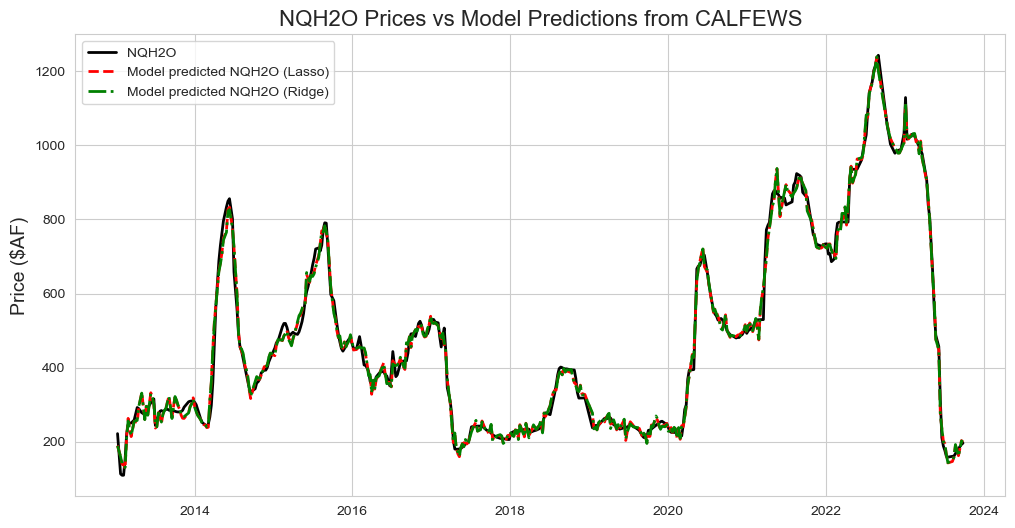

In [47]:
plt.figure(figsize=(12, 6))
# Create a time axis (e.g., 100 time points)
time = np.arange(len(y_train))
# Plot the original and fitted values
plt.plot(time_train_sorted, y_train_sorted, label='NQH2O', color='black', linewidth=2)  # Original values
plt.plot(time_train_sorted, y_pred_train_lasso_sorted, label='Model predicted NQH2O (Lasso)', color='red', linestyle='--', linewidth=2)  # Fitted values
plt.plot(time_train_sorted, y_pred_train_ridge_sorted, label='Model predicted NQH2O (Ridge)', color='green', linestyle='-.', linewidth=2)  # Fitted values

# Add title and labels
plt.title('NQH2O Prices vs Model Predictions from CALFEWS', fontsize=16)
# plt.xlabel('Time', fontsize=14)
plt.ylabel('Price ($AF)', fontsize=14)
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [48]:
# Step 2: Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Check how many components are selected
print(f"Number of components selected: {X_train_pca.shape[1]}")

# Step 3: Train models on PCA-transformed data

# Lasso Model
lasso = LassoCV(alphas=[0.1, 1, 10, 0.01], cv =3)
lasso.fit(X_train_pca, y_train)

y_pred_train_lasso_pca = lasso.predict(X_train_pca)
y_pred_test_lasso_pca = lasso.predict(X_test_pca)

r2_train_lasso = r2_score(y_train, y_pred_train_lasso_pca)
r2_test_lasso = r2_score(y_test, y_pred_test_lasso_pca)

print(f"Lasso R² (Train): {r2_train_lasso}")
print(f"Lasso R² (Test): {r2_test_lasso}")

# Ridge Model
ridge = RidgeCV(alphas=[0.1, 1, 10, 0.01], cv =3)
ridge.fit(X_train_pca, y_train)

y_pred_train_ridge_pca = ridge.predict(X_train_pca)
y_pred_test_ridge_pca = ridge.predict(X_test_pca)

r2_train_ridge = r2_score(y_train, y_pred_train_ridge)
r2_test_ridge = r2_score(y_test, y_pred_test_ridge)

print(f"Ridge R² (Train): {r2_train_ridge}")
print(f"Ridge R² (Test): {r2_test_ridge}")

Number of components selected: 28
Lasso R² (Train): 0.9035939943542505
Lasso R² (Test): 0.9035262180509789
Ridge R² (Train): 0.9925565106669413
Ridge R² (Test): 0.977151369449076


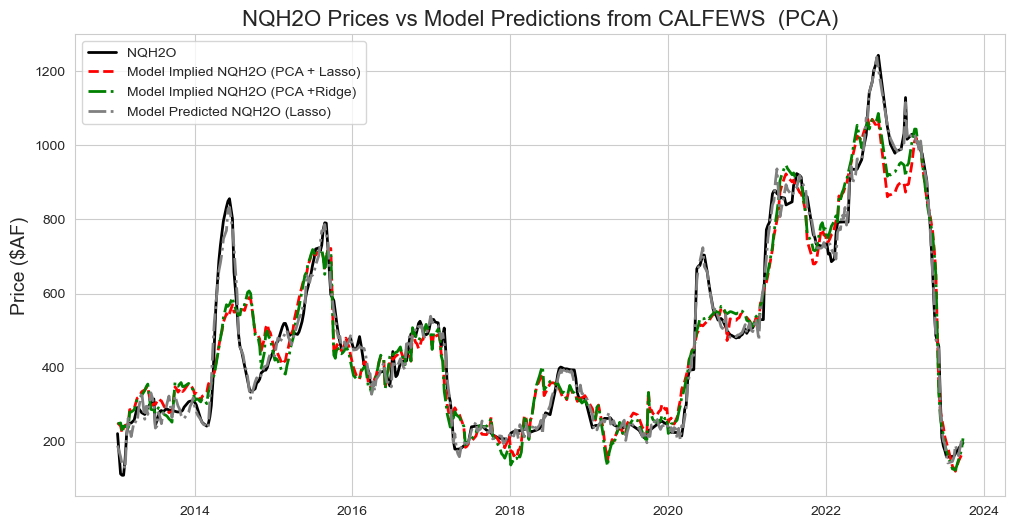

In [49]:
# Sort the training data by time
sorted_indices = np.argsort(time_train)  # Get indices that would sort time_train
time_train_sorted = time_train[sorted_indices]
y_train_sorted = y_train[sorted_indices]
y_pred_train_lasso_pca_sorted = y_pred_train_lasso_pca[sorted_indices]  # Ensure predictions are sorted too
y_pred_train_ridge_pca_sorted = y_pred_train_ridge_pca[sorted_indices]

#  Plot the sorted data
plt.figure(figsize=(12, 6))

# Plot original values (sorted)
plt.plot(time_train_sorted, y_train_sorted, label='NQH2O', color='black', linewidth=2)
plt.plot(time_train_sorted, y_pred_train_lasso_pca_sorted, label='Model Implied NQH2O (PCA + Lasso)', color='red', linestyle='--', linewidth=2)
plt.plot(time_train_sorted, y_pred_train_ridge_pca_sorted, label='Model Implied NQH2O (PCA +Ridge)', color='green', linestyle='-.', linewidth=2)
plt.plot(time_train_sorted, y_pred_train_lasso_sorted, label='Model Predicted NQH2O (Lasso)', color='grey', linestyle='-.', linewidth=2)

# Add title and labels
plt.title('NQH2O Prices vs Model Predictions from CALFEWS  (PCA)', fontsize=16)
# plt.xlabel('Time', fontsize=14)
plt.ylabel('Price ($AF)', fontsize=14)
plt.legend(loc='best')
plt.grid(True)

# Format the x-axis for dates (if needed)
# plt.gcf().autofmt_xdate()

# Show the plot
plt.show()

using PCA for dim reduction in regression ignores the relationship between X and y. So dropping low variance components while ignoring their relationship to y is a dubious idea.
* It is not uncommon to see that the major PCs are insignificant in a prediction model. The PC is the largest force or variation source in by definition, but not necessarily the one that correlates with any outcome variable with the strongest correlation.
* Both penalize low variance directions in X. 
* avoid under-fitting, we can always do hyper-parameter tuning to find best lambda.
While PCA has been widely used, it is often criticized as a black box model that lacks interpretability. It depends on the circumstances where the PCA is used. Sometimes, it is not easy to connect the identified principal components with physical entities. 

https://dataanalyticsbook.info/chapter-8-scalability-lasso-pca.html#:~:text=Both%20methods%20can%20reduce%20the,a.k.a.%2C%20the%20new%20features).


Alignment of pricing data - Tabular data 
Y - x1, x2,,, Xn 

# Feature selection + RF

c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.456e+03, tolerance: 2.388e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.740e+03, tolerance: 2.952e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


R² score: 0.9411750543141613
MSE_test: 5288.357038919645
R² score_train: 0.9943318222622178
MSE_train: 373.43051290625016


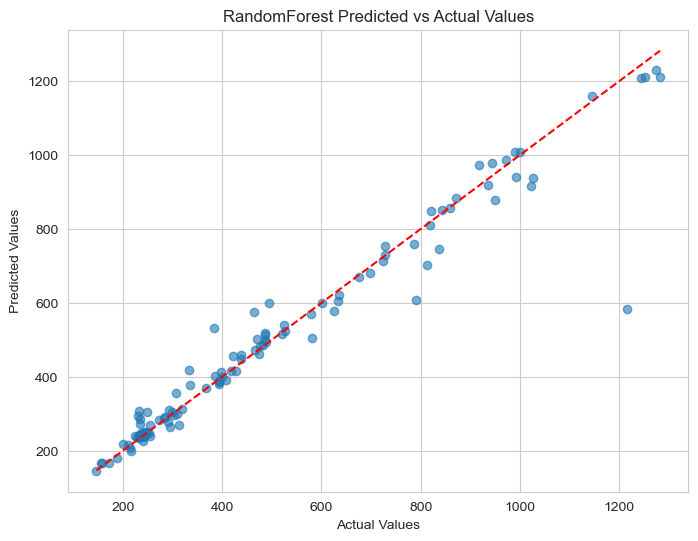

Selected Features and Coefficients:
Feature: belridge_pumping, Coefficient: -11.229937390286326
Feature: belridge_irr_demand, Coefficient: -11.408994335346193
Feature: belridge_tableA_carryover, Coefficient: -4.538825821323983
Feature: belridge_tableA_paper, Coefficient: -3.217258261261075
Feature: buenavista_tableA_projected, Coefficient: -19.269410689829158
Feature: buenavista_tableA_delivery, Coefficient: 32.75063102595168
Feature: buenavista_tableA_recharged, Coefficient: -11.36364439464107
Feature: buenavista_pumping, Coefficient: -6.637678898275881
Feature: buenavista_tableA_turnback, Coefficient: 9.649589691340823
Feature: buenavista_exchanged_GW, Coefficient: 209.66180871982664
Feature: buenavista_recover_banked, Coefficient: -132.48485535399286
Feature: cawelo_pumping, Coefficient: 8.129904803320867
Feature: cawelo_tableA_delivery, Coefficient: 12.6563757929963
Feature: cawelo_tableA_paper, Coefficient: -22.206520866916474
Feature: henrymiller_kern_flood_irrigation, Coefficien

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
X = merged_df.drop("NQH2O", axis=1).values
y = merged_df["NQH2O"].values
time = merged_df.index.values  
X_train, X_test, y_train, y_test, time_train,  _ = train_test_split(X, y, time, test_size=0.20, random_state=0)
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit LassoCV model with more iterations and adjusted tolerance
lasso_cv = LassoCV(cv=5, max_iter=5000, tol=1e-4)
lasso_cv.fit(X_train_scaled, y_train)

# Feature selection
sfm = SelectFromModel(lasso_cv, prefit=True)
X_train_selected = sfm.transform(X_train_scaled)
X_test_selected = sfm.transform(X_test_scaled)

# Train a Random Forest Regressor using the selected features
model = RandomForestRegressor(n_estimators=10, random_state=42)
model.fit(X_train_selected, y_train)

# Evaluate the model
y_pred = model.predict(X_test_selected)
y_pred_train = model.predict(X_train_selected)


# Calculate R² and MSE
r2_test = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
print(f"R² score: {r2_test}")
print(f"MSE_test: {mse_test}")
print(f"R² score_train: {r2_train}")
print(f"MSE_train: {mse_train}")

# Plot y_pred vs y_test
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('RandomForest Predicted vs Actual Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
plt.show()

# Analyze selected features and their importance
selected_feature_indices = np.where(sfm.get_support())[0]
selected_features = merged_df.columns[selected_feature_indices]
coefficients = lasso_cv.coef_

# Print selected features and their coefficients
print("Selected Features and Coefficients:")
selected_features_with_coefficients = zip(selected_features, coefficients[selected_feature_indices])
for feature, coef in selected_features_with_coefficients:
    print(f"Feature: {feature}, Coefficient: {coef}")


In [52]:
X_train_selected.shape

(156, 67)

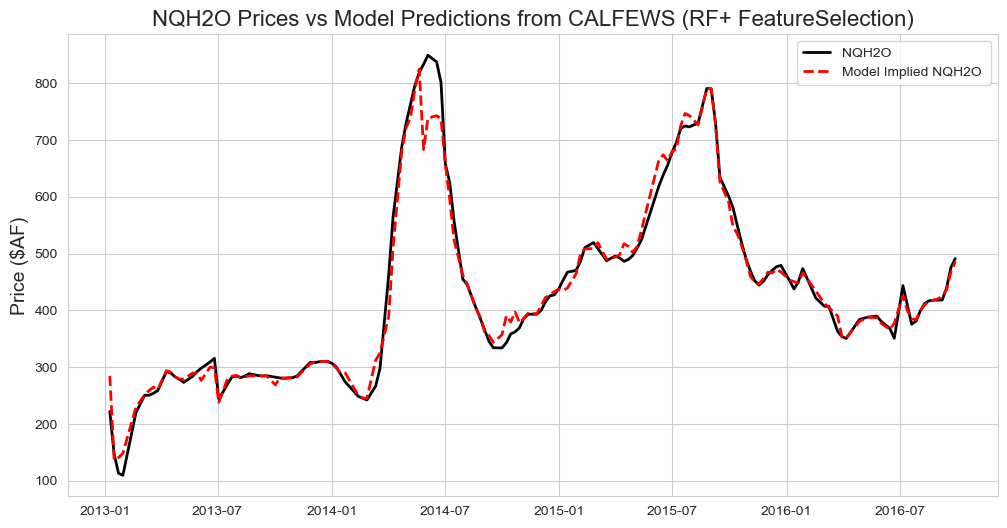

In [53]:
# Step 2: Sort the training data by time
sorted_indices = np.argsort(time_train)  # Get indices that would sort time_train
time_train_sorted = time_train[sorted_indices]
y_train_sorted = y_train[sorted_indices]
y_pred_train_sorted = y_pred_train[sorted_indices]  # Ensure predictions are sorted too

#  Plot the sorted data
plt.figure(figsize=(12, 6))

# Plot original values (sorted)
plt.plot(time_train_sorted, y_train_sorted, label='NQH2O', color='black', linewidth=2)
plt.plot(time_train_sorted, y_pred_train_sorted, label='Model Implied NQH2O ', color='red', linestyle='--', linewidth=2)

# Add title and labels
plt.title('NQH2O Prices vs Model Predictions from CALFEWS (RF+ FeatureSelection)', fontsize=16)
plt.ylabel('Price ($AF)', fontsize=14)
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()

# Agent based model

In [2]:
# !pip install mesa


In [3]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
import random

# Global Parameters
INITIAL_WATER_PRICE = 100  # Initial price per acre-foot of water
WATER_SUPPLY = 10000  # Initial water supply
PRICE_FLUCTUATION = 10  # Price change factor based on supply-demand
RESERVOIR_CAPACITY = 5000  # Capacity of irrigation district's water storage

# Irrigation District Agent
class IrrigationDistrict(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.water_storage = random.randint(1000, 3000)  # Initial water storage in acre-feet
        self.water_demand = random.randint(500, 1000)  # Annual water demand in acre-feet
        self.financial_balance = random.randint(100000, 200000)  # Initial financial capital in $

    def step(self):
        """Actions for each district in a time step (season/year)."""
        water_price = self.model.water_price

        # Determine how much water to buy or sell
        water_needed = self.water_demand - self.water_storage

        # Buy water if needed
        if water_needed > 0:
            cost_of_water = water_needed * water_price
            if self.financial_balance >= cost_of_water:
                # Purchase water to meet demand
                self.financial_balance -= cost_of_water
                self.water_storage += water_needed
                self.model.water_supply -= water_needed
            else:
                # If the district can't afford enough water, it buys as much as possible
                affordable_water = self.financial_balance // water_price
                self.financial_balance -= affordable_water * water_price
                self.water_storage += affordable_water
                self.model.water_supply -= affordable_water

        # If there's excess water, sell it
        elif water_needed < 0:
            water_to_sell = -water_needed
            revenue_from_sale = water_to_sell * water_price
            self.financial_balance += revenue_from_sale
            self.water_storage -= water_to_sell
            self.model.water_supply += water_to_sell

        # Update the model's water price based on the remaining water supply
        self.model.update_water_price()

class WaterMarketModel(Model):
    """The model for the California water market."""
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(10, 10, True)
        self.water_supply = WATER_SUPPLY  # Initial total water supply
        self.water_price = INITIAL_WATER_PRICE  # Initial water price per acre-foot

        # Create agents
        for i in range(self.num_agents):
            district = IrrigationDistrict(i, self)
            self.schedule.add(district)

    def update_water_price(self):
        """Update water price based on supply and demand."""
        if self.water_supply > WATER_SUPPLY * 0.8:
            self.water_price = max(INITIAL_WATER_PRICE - PRICE_FLUCTUATION, 10)
        elif self.water_supply < WATER_SUPPLY * 0.2:
            self.water_price = min(INITIAL_WATER_PRICE + PRICE_FLUCTUATION, 200)
        else:
            self.water_price += random.randint(-PRICE_FLUCTUATION, PRICE_FLUCTUATION)

    def step(self):
        """Advance the model by one step."""
        self.schedule.step()

# Run the model
model = WaterMarketModel(10)  # Create a model with 10 irrigation districts

for i in range(10):
    model.step()  # Run the model for 10 steps (years)

    # Output the current water price and supply after each step
    print(f"Year {i+1}: Water Price = {model.water_price}, Water Supply = {model.water_supply}")


Year 1: Water Price = 90, Water Supply = 22828
Year 2: Water Price = 90, Water Supply = 22828
Year 3: Water Price = 90, Water Supply = 22828
Year 4: Water Price = 90, Water Supply = 22828
Year 5: Water Price = 90, Water Supply = 22828
Year 6: Water Price = 90, Water Supply = 22828
Year 7: Water Price = 90, Water Supply = 22828
Year 8: Water Price = 90, Water Supply = 22828
Year 9: Water Price = 90, Water Supply = 22828
Year 10: Water Price = 90, Water Supply = 22828


In [10]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
import random

# Global Parameters
INITIAL_WATER_PRICE = 100  # Initial price per acre-foot of water
WATER_SUPPLY = 5000  # total water supply in the system
PRICE_FLUCTUATION = 20  # Increased price change factor based on supply-demand
TRANSACTION_COST_RATE = 0.05  # 5% transaction cost on water trades
RESERVOIR_CAPACITY = 5000  # Maximum reservoir capacity for irrigation districts
EXTERNAL_DEMAND_FLUCTUATION = 0.1  # Factor to randomly adjust water demand to simulate external factors
FACTOR = 1.2  # Scaling factor for price equation

# Here’s the modified model code to print the amount of water sold or bought by each district during each year/step.

class IrrigationDistrict(Agent):
    def __init__(self, unique_id, model, location):
        super().__init__(unique_id, model)
        self.water_storage = random.randint(500, 1500)  # Smaller initial water storage in acre-feet
        self.water_demand = random.randint(800, 1200)  # Higher annual water demand in acre-feet
        self.financial_balance = random.randint(50000, 150000)  # Smaller initial financial capital in $
        self.transaction_cost_rate = TRANSACTION_COST_RATE
        self.location = location  # "upstream" or "downstream"
        self.water_bought = 0  # Track water bought in a step
        self.water_sold = 0    # Track water sold in a step

    def step(self):
        """Actions for each district in a time step (season/year)."""
        self.water_bought = 0  # Reset water bought/sold at the start of each step
        self.water_sold = 0

        water_price = self.model.water_price
        transaction_cost = 0

        # Randomly adjust demand to simulate external factors
        self.water_demand += random.randint(-int(self.water_demand * EXTERNAL_DEMAND_FLUCTUATION), int(self.water_demand * EXTERNAL_DEMAND_FLUCTUATION))

        # Determine how much water to buy or sell
        water_needed = self.water_demand - self.water_storage

        # Add the district to buyers or sellers list based on water needs and location (upstream can only sell, downstream can only buy)
        if water_needed > 0 and self.location == "downstream":
            self.model.buyers.append(self)
        elif water_needed < 0 and self.location == "upstream":
            self.model.sellers.append(self)

class WaterMarketModel(Model):
    """The model for the California water market."""
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(10, 10, True)
        self.water_supply = WATER_SUPPLY  # Initial total water supply
        self.water_price = INITIAL_WATER_PRICE  # Initial water price per acre-foot
        self.buyers = []
        self.sellers = []

        # Create agents (irrigation districts)
        for i in range(self.num_agents):
            location = "upstream" if i < N / 2 else "downstream"  # Half of the agents are upstream, half are downstream
            district = IrrigationDistrict(i, self, location)
            self.schedule.add(district)

    def update_water_price(self):
        """Update water price based on supply and demand."""
        if self.water_supply > WATER_SUPPLY * 0.8:
            self.water_price = max(INITIAL_WATER_PRICE - PRICE_FLUCTUATION, 10)
        elif self.water_supply < WATER_SUPPLY * 0.2:
            self.water_price = min(INITIAL_WATER_PRICE + PRICE_FLUCTUATION, 300)  # Increased price fluctuation for scarcity
        else:
            self.water_price += random.randint(-PRICE_FLUCTUATION, PRICE_FLUCTUATION)

    def execute_trades(self):
        """Perform trades between buyers and sellers."""
        for buyer in self.buyers:
            for seller in self.sellers:
                if seller.water_storage > 0:
                    # Transaction cost for both buyer and seller
                    seller_transaction_cost = seller.water_storage * seller.transaction_cost_rate
                    buyer_transaction_cost = buyer.water_demand * buyer.transaction_cost_rate
                    
                    # Seller price equation: factor * (willingness-to-sell - transaction cost)
                    seller_price = FACTOR * (self.water_price - seller_transaction_cost)

                    # Buyer price equation: factor * (willingness-to-buy + transaction cost)
                    buyer_price = FACTOR * (self.water_price + buyer_transaction_cost)

                    # Simulate a trade if the buyer can afford the price
                    if buyer.financial_balance >= buyer_price:
                        water_transacted = min(buyer.water_demand, seller.water_storage)
                        total_cost = water_transacted * buyer_price

                        # Adjust buyer and seller balances
                        buyer.financial_balance -= total_cost
                        buyer.water_storage += water_transacted
                        buyer.water_bought += water_transacted  # Track amount of water bought
                        seller.financial_balance += water_transacted * seller_price
                        seller.water_storage -= water_transacted
                        seller.water_sold += water_transacted  # Track amount of water sold
                        self.water_supply -= water_transacted
                        if seller.water_storage == 0:
                            break

    def step(self):
        """Advance the model by one step."""
        # Clear previous buyers and sellers lists
        self.buyers = []
        self.sellers = []

        # Let agents take their steps
        self.schedule.step()

        # Update the water price based on the supply-demand dynamic
        self.update_water_price()

        # Execute the trades between buyers and sellers
        self.execute_trades()

# Run the model
model = WaterMarketModel(10)  # Create a model with 10 irrigation districts

for i in range(10):
    model.step()  # Run the model for 10 steps (years)

    # Output the current water price and supply after each step
    print(f"Year {i+1}: Water Price = {model.water_price}, Water Supply = {model.water_supply}")
    for agent in model.schedule.agents:
        print(f"Irrigation District {agent.unique_id} ({agent.location}): Water Storage = {agent.water_storage}, Financial Balance = {agent.financial_balance}, Water Bought = {agent.water_bought}, Water Sold = {agent.water_sold}")


Year 1: Water Price = 80, Water Supply = 3566
Irrigation District 0 (upstream): Water Storage = 816, Financial Balance = 117398, Water Bought = 0, Water Sold = 0
Irrigation District 1 (upstream): Water Storage = 944, Financial Balance = 130324, Water Bought = 0, Water Sold = 0
Irrigation District 2 (upstream): Water Storage = 891, Financial Balance = 76421, Water Bought = 0, Water Sold = 0
Irrigation District 3 (upstream): Water Storage = 581, Financial Balance = 123482, Water Bought = 0, Water Sold = 0
Irrigation District 4 (upstream): Water Storage = 0, Financial Balance = 108737.54, Water Bought = 0, Water Sold = 1434
Irrigation District 5 (downstream): Water Storage = 1020, Financial Balance = 23080.0, Water Bought = 485, Water Sold = 0
Irrigation District 6 (downstream): Water Storage = 1216, Financial Balance = 129397, Water Bought = 0, Water Sold = 0
Irrigation District 7 (downstream): Water Storage = 1401, Financial Balance = 131745, Water Bought = 0, Water Sold = 0
Irrigation 